In [ ]:
# 라이브러리 불러오기
'''메인 라이브러리'''
import numpy as np
import pandas as pd

'''시각화 관련 라이브러리'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 마케팅 캠페인 데이터셋
* 어떤 특성(피처)을 가진 소비자가 마케팅 캠페인에 더 많이 참여했는지 분석하고자 합니다
* (참고) [캐글](https://www.kaggle.com/rodsaldanha/arketing-campaign) 


In [ ]:
base_path = "경로"
marketing = pd.read_csv('/content/drive/MyDrive/코드/코드/데이터 사이언스 랩/22-1학기/10강 unsupervised learning/marketing_campaign.csv', \
                 sep =';')

### 전처리
* (참고) [EDA B조 코드](https://github.com/yonsei-dsl/7th_EDA/blob/main/B%EC%A1%B0/EDA_B%EC%A1%B0_%EC%BD%94%EB%93%9C.ipynb) - 감사합니다 :)

In [ ]:
# company에 enrol한 연도, 월 따로 저장
marketing.Dt_Customer = pd.to_datetime(marketing.Dt_Customer)
marketing["enrol_year"] = marketing.Dt_Customer.dt.strftime("%Y") # strftime: 날짜와 시간(datetime)을 문자열로 출력
marketing["enrol_month"] = marketing.Dt_Customer.dt.strftime("%m") # strptime: 날짜와 시간 형식의 문자열을 datetime으로 변환

In [ ]:
from datetime import datetime
# 현재까지의 회원일수 따로 저장
y = pd.to_datetime(datetime.today().strftime("%Y-%m-%d"))

In [ ]:
marketing['days'] = y - marketing.Dt_Customer
marketing['days'] = marketing['days'] / np.timedelta64(1, 'D')
marketing['days'] = marketing['days'].astype(int) # int형으로 변환

In [ ]:
# 나이를 age에 저장
marketing['age'] = 2022-marketing['Year_Birth']

In [ ]:
marketing.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response',
       'enrol_year', 'enrol_month', 'days', 'age'],
      dtype='object')

5차례의 마케팅 캠페인에 총 몇 회 참여했는지에 따라 소비자 군집을 만들고자 합니다 \
 

In [ ]:
marketing.head(1)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,enrol_year,enrol_month,days,age
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1,2012,09,3454,65


In [ ]:
# 소비자별 총 캠페인 참여 횟수를 구하여 CampaignAttendance에 저장
# (힌트) 'AcceptedCmpN'의 자료형은 ?!
marketing['CampaignAttendance'] = marketing['AcceptedCmp1'] + marketing['AcceptedCmp2'] + marketing['AcceptedCmp3'] + marketing['AcceptedCmp4'] + marketing['AcceptedCmp5']

In [ ]:
# 5번의 마케팅 캠페인 모두에 참여한 소비자는 없음
marketing['CampaignAttendance'].unique()

array([0, 1, 2, 3, 4])

분석을 위해 **연속형 변수**만을 피처로 사용하겠습니다
* (참고) https://www.kaggle.com/ededhiscalifh/marketing-campaign-eda-practice/notebook

In [ ]:
ID = ['ID']
features = ['days', 'age', 'Income', 'Recency', 'MntWines', 'MntFruits',\
                     'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',\
                     'MntGoldProds', 'NumDealsPurchases','NumWebPurchases', \
                     'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']
label = ['CampaignAttendance'] 

In [ ]:
print(len(features),"차원 데이터입니다")

15 차원 데이터입니다


In [ ]:
campaign = marketing[ID + features + label]

In [ ]:
campaign.head(5)

,ID,days,age,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,CampaignAttendance
0,5524,3454,65,58138.0,58,635,88,546,172,88,88,3,8,10,4,7,0
1,2174,2904,68,46344.0,38,11,1,6,2,1,6,2,1,1,2,5,0
2,4141,3103,57,71613.0,26,426,49,127,111,21,42,1,8,2,10,4,0
3,6182,2930,38,26646.0,26,11,4,20,10,3,5,2,2,0,4,6,0
4,5324,2952,41,58293.0,94,173,43,118,46,27,15,5,5,3,6,5,0


In [ ]:
# 결측값 제거
campaign = campaign.dropna()

In [ ]:
campaign.isnull().sum()

ID                     0
days                   0
age                    0
Income                 0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
CampaignAttendance     0
dtype: int64

In [ ]:
campaign.shape 

(2216, 17)

# PCA
* 클러스터링을 수행하기 전에 PCA를 사용해 추후 클러스터링 단계에서 사용할 주성분 개수를 구하도록 하겠습니다
* 주성분 개수는 분산 설명 비율이 90% 이상이 되게끔 하는 값으로 구하겠습니다

### fit / transform / fit_transform 개인 정리
 --------------------------------------------------------------------------

#### 1. fit() 
 

fit이란 정규화를 하는 것이다.

MinMax에서는 최소와 최대를 인지하는 작업이다.

Standardscler에서는 평균과 편차를 계산하는 작업이다

 --------------------------------------------------------------------------

#### 2. transform() & fit_transform()
 

예를 들어 MinMax를 하는 train 데이터에 (2, 3, 4, 5)가 들어있다. 이걸 fit_transform() 하면 최솟값인 2는 0으로 최댓값인 5는 1로 매핑된다.

근데 test 데이터에 (2, 3, 4, 6)이 들어있다. train 데이터에서는 5가 최대라고 했는데 6이 있다면 어떻게 해야 할까??

 

5를 그대로 1로 매핑하고 6을 1.2.로 매핑한다. train데이터와 test데이터가 같은 조건으로 맞춰줘야 하기 때문에 test데이터에서는 fit()을 하지 않고 transform()만 적용해야 한다.

--------------------------------------------------------------------------
#### 3. 정리하면

1. train 데이터에서 fit_transform()을 하여 범위를 맞추고 모델을 생성한다. 

2. 위에서 사용한 범위를 그대로 이용하기 위해 test 데이터에서는 새로 fit()을 하지 않고 trasform()만 사용한다.



출처: https://wpaud16.tistory.com/148 [Dol_Cong]

In [ ]:
# 데이터프레임의 형태로 피처셋과 레이블셋을 할당해주세요
X = pd.DataFrame(marketing[features])
y = pd.DataFrame(marketing[label])

In [ ]:
X.head(1)

,days,age,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
0,3454,65,58138.0,58,635,88,546,172,88,88,3,8,10,4,7


In [ ]:
y.head(10)

,CampaignAttendance
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,1


In [ ]:
# Scaling 먼저 해주세요
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_std  = scaler.fit_transform(X)

# 시각화 위해 데이터프레임으로 변환
X_std = pd.DataFrame(X_std, columns=X.columns, index=list(X.index.values))

In [ ]:
X_std

,days,age,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
0,1.531185,0.985345,0.234063,0.307039,0.983781,1.551577,1.679702,2.462147,1.476500,0.843207,0.349414,1.409304,2.510890,-0.550785,0.693904
1,-1.190545,1.235733,-0.234559,-0.383664,-0.870479,-0.636301,-0.713225,-0.650449,-0.631503,-0.729006,-0.168236,-1.110409,-0.568720,-1.166125,-0.130463
2,-0.205773,0.317643,0.769478,-0.798086,0.362723,0.570804,-0.177032,1.345274,-0.146905,-0.038766,-0.685887,1.409304,-0.226541,1.295237,-0.542647
3,-1.061881,-1.268149,-1.017239,-0.798086,-0.870479,-0.560857,-0.651187,-0.503974,-0.583043,-0.748179,-0.168236,-0.750450,-0.910898,-0.550785,0.281720
4,-0.953012,-1.017761,0.240221,1.550305,-0.389085,0.419916,-0.216914,0.155164,-0.001525,-0.556446,1.384715,0.329427,0.115638,0.064556,-0.130463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,0.135680,0.150717,0.356642,-0.107383,1.203678,0.419916,0.066692,0.081926,2.203398,3.891766,-0.168236,1.769263,0.115638,-0.550785,-0.130463
2236,-1.655713,1.903435,0.467539,0.237969,0.303291,-0.661449,-0.606873,-0.687068,-0.655733,-0.690659,2.420015,1.409304,-0.226541,-0.243114,0.693904
2237,-0.982703,-1.017761,0.188091,1.446700,1.795020,0.545656,0.221789,-0.101168,-0.364974,-0.383886,-0.685887,-0.750450,0.115638,2.218248,0.281720
2238,-0.977755,1.068807,0.675388,-1.419719,0.368666,0.092992,0.208495,0.777683,0.071165,0.325527,-0.168236,0.689386,0.799996,1.295237,-0.954831


In [ ]:
X_std.isnull().sum()

days                    0
age                     0
Income                 24
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
dtype: int64

In [ ]:
X_std = X_std.dropna()

원본 차원의 수만큼 총 15개의 주성분을 생성하겠습니다

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=15)
X_pca = pca.fit_transform(X_std) # PCA에는 scaling한 데이터를 넣어주어야 합니다

In [ ]:
# 데이터프레임 변환
X_pca = pd.DataFrame(data=X_pca) 

In [ ]:
X_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,3.781894,1.453257,-1.182614,0.487965,-1.704395,0.611771,0.932520,0.295679,2.122465,-0.486601,-0.368861,0.443672,-0.110001,-0.540231,0.347386
1,-2.111804,-1.248797,1.426373,-0.259897,-0.726102,-0.097015,0.506799,0.284641,0.242908,0.105656,0.161425,-0.007978,0.223482,-0.090343,-0.046740
2,1.662941,-0.080254,0.487033,-0.962874,-0.205203,-0.411293,-0.904243,-1.048572,-0.433626,-0.350795,-0.042589,1.224439,-0.513222,-0.075257,0.077632
3,-2.370005,-0.998860,-0.559926,-0.906186,0.778179,-0.568965,0.025845,-0.127782,-0.044675,-0.232945,-0.323235,-0.051496,-0.021231,0.069930,-0.063727
4,-0.066274,0.097271,-0.205345,1.301609,1.311072,-1.346331,1.134668,-0.439116,0.010335,-0.174888,0.346998,0.346930,-0.156380,-0.351651,0.029201


In [ ]:
# 100%가 되어야 합니다
print("15개의 주성분에 의해 설명되는 분산 비율: ", sum(pca.explained_variance_ratio_))

15개의 주성분에 의해 설명되는 분산 비율:  1.0


In [ ]:
# 15개의 주성분을 중요도 순으로 나열합니다
importanceOfPrincipalComponents = pd.DataFrame(data=pca.explained_variance_ratio_)
importanceOfPrincipalComponents # 추출된 주성분은 디폴트로 중요도 순으로 정렬됨

,0
0,0.378750
1,0.118139
2,0.077975
3,0.067285
4,0.054652
5,0.050881
6,0.043889
7,0.042115
8,0.032039
9,0.028867


In [ ]:
pca_result = pd.DataFrame(X_pca.values)
pca_result['label'] = y
pca_result['label'].value_counts()

0    1759
1     320
2      82
3      44
4      11
Name: label, dtype: int64

In [ ]:
pca_result.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,label
0,3.781894,1.453257,-1.182614,0.487965,-1.704395,0.611771,0.932520,0.295679,2.122465,-0.486601,-0.368861,0.443672,-0.110001,-0.540231,0.347386,0
1,-2.111804,-1.248797,1.426373,-0.259897,-0.726102,-0.097015,0.506799,0.284641,0.242908,0.105656,0.161425,-0.007978,0.223482,-0.090343,-0.046740,0
2,1.662941,-0.080254,0.487033,-0.962874,-0.205203,-0.411293,-0.904243,-1.048572,-0.433626,-0.350795,-0.042589,1.224439,-0.513222,-0.075257,0.077632,0
3,-2.370005,-0.998860,-0.559926,-0.906186,0.778179,-0.568965,0.025845,-0.127782,-0.044675,-0.232945,-0.323235,-0.051496,-0.021231,0.069930,-0.063727,0
4,-0.066274,0.097271,-0.205345,1.301609,1.311072,-1.346331,1.134668,-0.439116,0.010335,-0.174888,0.346998,0.346930,-0.156380,-0.351651,0.029201,0


총 분산의 90%이상을 잡아내는 주성분의 개수를 구하세요!
* 이후 클러스터링 학습 시 해당 개수만큼 차원 축소한 피처셋을 이용할 겁니다

In [ ]:
# 처음 N개 주성분의 중요도
importanceOfPrincipalComponents = importanceOfPrincipalComponents.T

In [ ]:
print('처음 2개의 주성분에 의해 설명되는 분산 비율: ',
      importanceOfPrincipalComponents.loc[:,0:1].sum(axis=1).values)
print('처음 7개의 주성분에 의해 설명되는 분산 비율: ',
      importanceOfPrincipalComponents.loc[:,0:6].sum(axis=1).values)
print('처음 8개의 주성분에 의해 설명되는 분산 비율: ',
      importanceOfPrincipalComponents.loc[:,0:7].sum(axis=1).values)
print('처음 9개의 주성분에 의해 설명되는 분산 비율: ',
      importanceOfPrincipalComponents.loc[:,0:8].sum(axis=1).values)
print('처음 10개의 주성분에 의해 설명되는 분산 비율: ',
      importanceOfPrincipalComponents.loc[:,0:9].sum(axis=1).values)
print('처음 11개의 주성분에 의해 설명되는 분산 비율: ',
      importanceOfPrincipalComponents.loc[:,0:10].sum(axis=1).values)

처음 2개의 주성분에 의해 설명되는 분산 비율:  [0.49688929]
처음 7개의 주성분에 의해 설명되는 분산 비율:  [0.79157215]
처음 8개의 주성분에 의해 설명되는 분산 비율:  [0.83368675]
처음 9개의 주성분에 의해 설명되는 분산 비율:  [0.86572614]
처음 10개의 주성분에 의해 설명되는 분산 비율:  [0.89459305]
처음 11개의 주성분에 의해 설명되는 분산 비율:  [0.9223714]


# 총 분산의 90%이상을 잡아내는 주성분의 개수 = 11개 이상

In [ ]:
# 처음 두 개의 주성분을 이용하여 2차원 평면에 데이터셋의 분포를 나타내겠습니다
def scatterPlot(xDF, yDF):
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index) 
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", \
               data=tempDF, fit_reg=False)
    ax = plt.gca()
    plt.show()

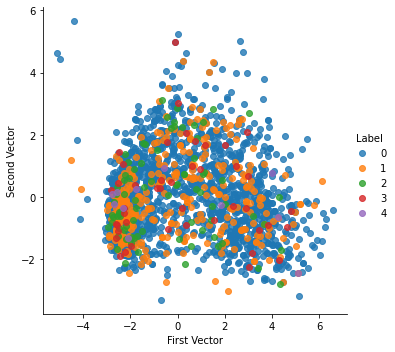

In [ ]:
# 설명력이 별로군여 ㅠㅅㅠ
scatterPlot(X_pca, y)

# 클러스터링
* PCA를 통해 구한 상위 $x$개(분산 설명력 90% 이상)의 주성분을 사용하여 클러스터링을 하고자 합니다

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
# 파라미터를 설정해주세요
n_clusters = 5 # 군집수
n_init = 11 # 초기화 횟수
max_iter = 300 # 학습(군집 재할당)의 반복 횟수
tol = 0.0001 # 너무 오랜 시간 반복하는 경우에 대비해 tol만큼 줄어들지 않으면 조기 종료
random_state = 42

kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, \
                max_iter=max_iter, tol=tol, random_state=random_state)

In [ ]:
# 처음 N개의 주성분만을 이용하고자 합니다
cutoff = 10 # 앞서 구한 주성분 개수 - 1
X_train_Kmeans = X_pca.loc[:,0:cutoff]

kmeans = kmeans.fit(X_train_Kmeans) 

In [ ]:
# 클러스터링 결과 
result = X_train_Kmeans.copy()

result["cluster"] =  kmeans.labels_ 

In [ ]:
result.head()

,0,1,2,3,4,5,6,7,8,9,10,cluster
0,3.781894,1.453257,-1.182614,0.487965,-1.704395,0.611771,0.932520,0.295679,2.122465,-0.486601,-0.368861,1
1,-2.111804,-1.248797,1.426373,-0.259897,-0.726102,-0.097015,0.506799,0.284641,0.242908,0.105656,0.161425,3
2,1.662941,-0.080254,0.487033,-0.962874,-0.205203,-0.411293,-0.904243,-1.048572,-0.433626,-0.350795,-0.042589,2
3,-2.370005,-0.998860,-0.559926,-0.906186,0.778179,-0.568965,0.025845,-0.127782,-0.044675,-0.232945,-0.323235,3
4,-0.066274,0.097271,-0.205345,1.301609,1.311072,-1.346331,1.134668,-0.439116,0.010335,-0.174888,0.346998,4


In [ ]:
def ClusteringPlot(xDF):
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,xDF["cluster"]), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "cluster"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="cluster", \
               data=tempDF, fit_reg=False)
    ax = plt.gca()
    plt.show()

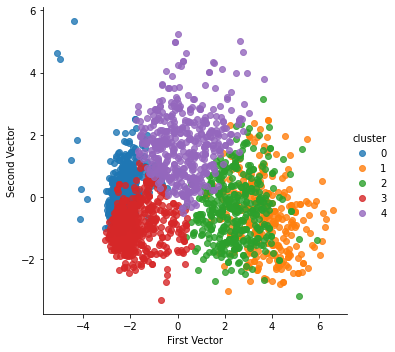

In [ ]:
ClusteringPlot(result)

결과물에 대한 해석 한두줄 적어주세요! 수고 많으셨습니다 :)